In [58]:
import os, cv2
import matplotlib.pyplot as plt
import numpy as np
from library.ron_utils import *
from torch_lib.KITTI_Dataset import *

def _evaluation(val_ids, diff_list, cls_list, result_root, gt_root='Kitti/training/label_2'):
    for id_ in val_ids:
        gt_label = os.path.join(gt_root, f'{id_}.txt')
        gt_objects = [Object3d(line) for line in open(gt_label).readlines()]
        reg_label = os.path.join(result_root, f'{id_}.txt')
        reg_objects = [Object3d(line) for line in open(reg_label).readlines()]
        for i in range(len(gt_objects)):
            gt = gt_objects[i]
            if gt.cls_type.lower() in cls_list and gt.level in diff_list:
                #TODO
                print()

gt_root='Kitti/training/label_2'
img_root='Kitti/training/image_2'
baseline_root = 'KITTI_labels_before1020/0928_BL/KITTI_BL_B4_vgg'
#result_root='KITTI_labels/1021/KITTI_DA_B4_iou_vgg' #單iou_loss沒有提升iou太多
#result_root='KITTI_labels/1021/KITTI_DA_B4_dep_vgg' #depth_loss可以提升iou
result_root='KITTI_labels/1020/KITTI_D_B4_dep_iou_vgg'
cls_list = ['car']
diff_list = [1, 2]
val_ids = [x.strip() for x in open('Kitti/ImageSets/val.txt').readlines()]

bl_ious = list()
bl_alphas = list()
reg_ious = list()
reg_alphas = list()
for id_ in val_ids:
    img = cv2.cvtColor(cv2.imread(f'{img_root}/{id_}.png'), cv2.COLOR_BGR2RGB)
    gt_label = os.path.join(gt_root, f'{id_}.txt')
    gt_objects = [Object3d(line) for line in open(gt_label).readlines()]
    
    bl_label = os.path.join(baseline_root, f'{id_}.txt')
    bl_objects = [Object3d(line) for line in open(bl_label).readlines()]
    
    reg_label = os.path.join(result_root, f'{id_}.txt')
    reg_objects = [Object3d(line) for line in open(reg_label).readlines()]
    count = 0
    cam_to_img = FrameCalibrationData(f'Kitti/training/calib/{id_}.txt').p2
    for i in range(len(gt_objects)):
        gt = gt_objects[i]
        if gt.cls_type.lower() in cls_list and gt.level in diff_list:
            #TODO
            gt_box2d = gt.box2d

            bl = bl_objects[count]
            bl_location = [bl.pos[0], bl.pos[1]-(bl.dim[0]/2), bl.pos[2]]
            bl_box2d_prj = loc3d_2_box2d_np(bl.ry, bl_location, bl.dim, cam_to_img)            
            
            reg = reg_objects[count]
            reg_location = [reg.pos[0], reg.pos[1]-(reg.dim[0]/2), reg.pos[2]]
            reg_box2d_prj = loc3d_2_box2d_np(reg.ry, reg_location, reg.dim, cam_to_img)
            
            
            cv2.rectangle(img, (bl_box2d_prj[0], bl_box2d_prj[1]), (bl_box2d_prj[2], bl_box2d_prj[3]), (0,0,255), 2)
            cv2.rectangle(img, (reg_box2d_prj[0], reg_box2d_prj[1]), (reg_box2d_prj[2], reg_box2d_prj[3]), (255,0,0), 1)
            
            bl_iou = round(calc_IoU_2d(gt_box2d, bl_box2d_prj), 3)
            reg_iou = round(calc_IoU_2d(gt_box2d, reg_box2d_prj), 3)
            #print('IoU', bl_iou, reg_iou)
            #print('Alpha', gt.alpha, reg.alpha)
            #print('Dim', gt.dim, reg.dim)
            bl_alphas.append(bl.alpha)
            bl_ious.append(bl_iou)
            reg_alphas.append(reg.alpha)
            reg_ious.append(reg_iou)
            count += 1
    '''
    if count > 0 :
        plt.imshow(img)
        plt.show()
    if count > 10:
        break
    '''

bl_ious = np.array(bl_ious)
reg_ious = np.array(reg_ious)
bl_alphas = np.array(bl_alphas)
reg_alphas = np.array(reg_alphas)

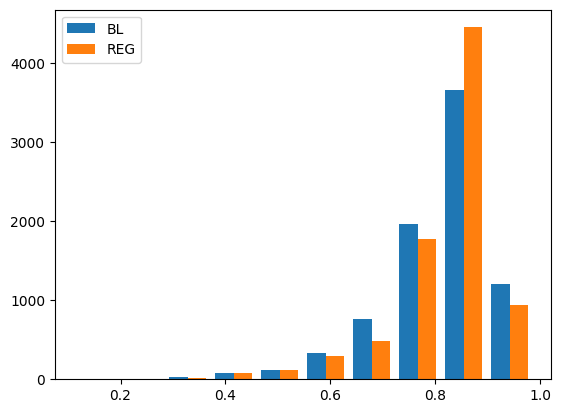

MIN 0.137 0.109
MEAN 0.8066349264705882 0.8155301470588237
STD 0.10509273650179526 0.09745748984274612


In [59]:
plt.hist([bl_ious, reg_ious], label=['BL', 'REG'])
plt.legend(loc='upper left')
plt.show()
print('MIN', bl_ious.min(), reg_ious.min())
print('MEAN', bl_ious.mean(), reg_ious.mean())
print('STD', bl_ious.std(), reg_ious.std())

#dep: min:0.137,0.337, mean:0.806 0.820
#dep_iou: min:0.137,0.109, mean:0.806 0.815

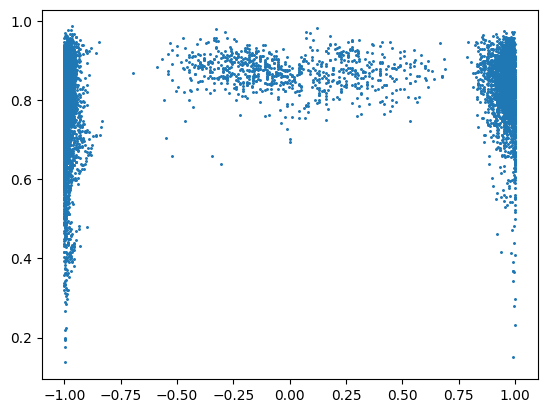

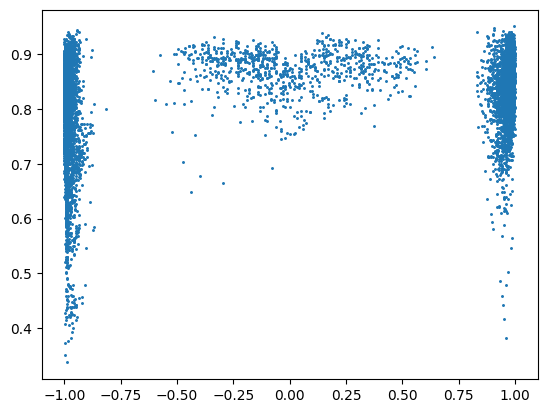

In [57]:
plt.scatter(x=np.sin(bl_alphas), y=bl_ious, marker='.', s=5)
#plt.legend(loc='upper left')
plt.show()

plt.scatter(x=np.sin(reg_alphas), y=reg_ious, marker='.', s=5)
#plt.legend(loc='upper left')
plt.show()